### Get the Environment Ready

In [1]:
from IPython.core.display import clear_output
!wget https://raw.githubusercontent.com/rahulrajpr/references/main/requirements_tf_cert_exam.txt
clear_output()

In [2]:
!wget https://raw.githubusercontent.com/rahulrajpr/references/main/helper_functions.py
clear_output()

In [3]:
!pip install -r requirements_tf_cert_exam.txt
!pip install split_folders
clear_output()

> import libraries

In [4]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import random
import scipy
import matplotlib.pyplot as plt

In [5]:
print(f'tensorflow version : {tf.__version__}')
print(f'pandas version : {pd.__version__}')
print(f'numpy version : {np.__version__}')
print(f'scipy version : {scipy.__version__}')

tensorflow version : 2.10.0
pandas version : 1.4.2
numpy version : 1.22.4
scipy version : 1.7.3


### Donwload the Data

In [6]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2023-04-05 06:58:37--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.12.128, 172.217.194.128, 74.125.68.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.12.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  23.2MB/s    in 7.9s    

2023-04-05 06:58:46 (20.4 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [7]:
from helper_functions import unzip_untar_data

In [8]:
unzip_untar_data('10_food_classes_10_percent.zip')

File extension : .zip
File extracting.......
Completed successfully


### Inspect Classes

In [9]:
classes = os.listdir('/content/10_food_classes_10_percent/train')
num_classes = len(classes)
num_classes

10

### Show Random Samples

In [10]:
dir = '/content/10_food_classes_10_percent'
train_dir = '/content/10_food_classes_10_percent/train'
test_dir = '/content/10_food_classes_10_percent/test'

In [11]:
from helper_functions import plot_random_image_from_dir

In [12]:
plot_random_image_from_dir(dir_name = train_dir, num_classes= num_classes, num_samples = 3)

Output hidden; open in https://colab.research.google.com to view.

### Read the directory into datasets

In [13]:
LABEL_MODE = 'categorical'
IMG_SIZE = (224,224)
BS = 32

COLOR_CHANNEL = 3

INPUT_SHAPE = IMG_SIZE + (COLOR_CHANNEL,)
INPUT_SHAPE

(224, 224, 3)

In [14]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(directory = train_dir, 
                                                               label_mode = LABEL_MODE,
                                                               image_size = IMG_SIZE,
                                                               batch_size = BS,
                                                               shuffle = True)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(directory = test_dir,
                                                              label_mode = LABEL_MODE,
                                                              image_size = IMG_SIZE,
                                                              batch_size = BS,
                                                              shuffle = False)

train_ds, test_ds

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


(<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>,
 <BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>)

### Access the Labels

In [15]:
test_labels = [np.argmax(x.numpy(), axis = 0) for x in test_ds.unbatch().map(lambda x,y :y)]
test_labels[:5]

[0, 0, 0, 0, 0]

In [16]:
train_labels = [np.argmax(x.numpy(), axis = 0) for x in train_ds.unbatch().map(lambda x,y :y)]
train_labels[:5]

[9, 3, 4, 0, 0]

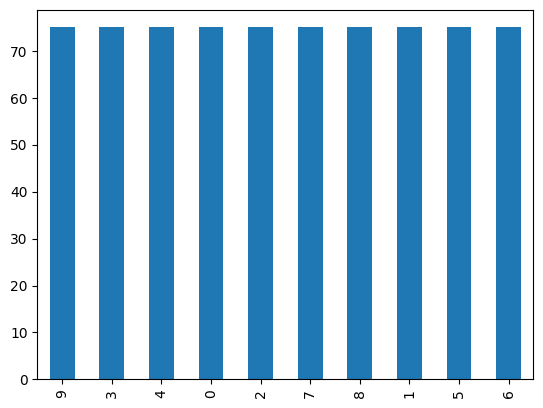

In [17]:
pd.Series(train_labels).value_counts().plot(kind = 'bar');

Inference : The label looks pretty balanced

### Create the data Pipeline

In [18]:
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)
train_ds, test_ds

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>)

### Setting up the Callbacks 

In [19]:
from helper_functions import create_model_checkpoint

### Create a Normalization Layer

In [20]:
from tensorflow.keras import layers

In [21]:
norm_layer = layers.Rescaling(scale = 1/255.0)

> Test the norm layer

In [22]:
for item in train_ds.unbatch().map(lambda x ,y : x):
  print('items values\n')
  print(item)
  print('\nnormalized values\n')
  print(norm_layer(item))
  break

items values

tf.Tensor(
[[[ 95.41326    19.556122    1.8418365]
  [ 94.668365   22.954082    7.5714293]
  [ 88.92347    26.071428   12.367347 ]
  ...
  [ 41.58164    11.010167   16.010166 ]
  [ 41.43883     9.510271   12.153063 ]
  [ 44.36215    13.362148   11.004971 ]]

 [[ 71.37755    22.97449    12.709185 ]
  [ 66.49489    22.413263   14.994898 ]
  [ 59.71428    20.770407   15.698978 ]
  ...
  [ 39.428635    7.6429005  12.857164 ]
  [ 45.061195   13.0662985  15.908107 ]
  [ 43.71936     9.71936     8.362183 ]]

 [[ 43.632652   26.846937   26.561224 ]
  [ 41.397957   25.32653    25.969387 ]
  [ 42.40306    28.02551    30.357143 ]
  ...
  [ 42.663258    8.168306   13.663212 ]
  [ 37.979694    3.979693    4.979693 ]
  [ 42.948765    8.948765    7.948765 ]]

 ...

 [[ 54.974506   45.27039     6.5510077]
  [ 52.244915   39.887707    4.673443 ]
  [ 56.265335   43.908127   10.030609 ]
  ...
  [169.05083   165.38753   127.38753  ]
  [173.98463   171.77037   134.8723   ]
  [173.01      169.

### Transfer Learning - Feature Extraction

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import tensorflow_hub as hub

### Resnet

In [24]:
resnet = Sequential([hub.KerasLayer(handle = "https://tfhub.dev/google/imagenet/resnet_v2_101/classification/5",
                                    trainable = False,
                                    input_shape = INPUT_SHAPE)])

In [25]:
inputs = tf.keras.Input(shape = INPUT_SHAPE)
x = norm_layer(inputs) # this is important for the resnet model to perform
x = resnet(x)
x = layers.Dense(units = 63, activation = 'relu')(x)
outputs = layers.Dense(num_classes, activation = 'softmax')(x)

model_1 = tf.keras.Model(inputs = inputs, outputs = outputs, name = 'model_1')

model_1.compile(loss = tf.keras.losses.categorical_crossentropy,
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 sequential (Sequential)     (None, 1001)              44677609  
                                                                 
 dense (Dense)               (None, 63)                63126     
                                                                 
 dense_1 (Dense)             (None, 10)                640       
                                                                 
Total params: 44,741,375
Trainable params: 63,766
Non-trainable params: 44,677,609
_________________________________________________________________


In [26]:
history_1 = model_1.fit(train_ds,
                        epochs = 10,
                        steps_per_epoch = len(train_ds),
                        validation_data = test_ds,
                        validation_steps = len(test_ds),
                        callbacks = [create_model_checkpoint(model_name = model_1.name)])

Epoch 1/10
24/24 [==============================] - 35s 806ms/step - loss: 1.6907 - accuracy: 0.4867 - val_loss: 0.9526 - val_accuracy: 0.6788
Epoch 2/10
24/24 [==============================] - 16s 652ms/step - loss: 0.6410 - accuracy: 0.7840 - val_loss: 0.7604 - val_accuracy: 0.7492
Epoch 3/10
24/24 [==============================] - 16s 652ms/step - loss: 0.4080 - accuracy: 0.8760 - val_loss: 0.7053 - val_accuracy: 0.7716
Epoch 4/10
24/24 [==============================] - 15s 625ms/step - loss: 0.2484 - accuracy: 0.9413 - val_loss: 0.7271 - val_accuracy: 0.7612
Epoch 5/10
24/24 [==============================] - 15s 619ms/step - loss: 0.1688 - accuracy: 0.9600 - val_loss: 0.7023 - val_accuracy: 0.7652
Epoch 6/10
24/24 [==============================] - 15s 624ms/step - loss: 0.1161 - accuracy: 0.9813 - val_loss: 0.7246 - val_accuracy: 0.7656
Epoch 7/10
24/24 [==============================] - 17s 681ms/step - loss: 0.0771 - accuracy: 0.9987 - val_loss: 0.7137 - val_accuracy: 0.7748

In [27]:
model_1.load_weights('checkpoints/model_1.h5')
model_1.evaluate(test_ds)

79/79 [==============================] - 12s 147ms/step - loss: 0.7277 - accuracy: 0.7768


[0.727703332901001, 0.7767999768257141]

### Efficient Net

In [28]:
eff_net = Sequential([hub.KerasLayer(handle = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1",
                                    trainable = False,
                                    input_shape = INPUT_SHAPE)], name = 'eff_net')

In [29]:
inputs = tf.keras.Input(shape = INPUT_SHAPE)
x = norm_layer(inputs)
x = eff_net(x)
x = layers.Dense(units = 63, activation = 'relu')(x)
outputs = layers.Dense(num_classes, activation = 'softmax')(x)

model_2 = tf.keras.Model(inputs = inputs, outputs = outputs, name = 'model_2')

model_2.compile(loss = tf.keras.losses.categorical_crossentropy,
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 eff_net (Sequential)        (None, 1280)              4049564   
                                                                 
 dense_2 (Dense)             (None, 63)                80703     
                                                                 
 dense_3 (Dense)             (None, 10)                640       
                                                                 
Total params: 4,130,907
Trainable params: 81,343
Non-trainable params: 4,049,564
_________________________________________________________________


In [30]:
history_2 = model_2.fit(train_ds,
                        epochs = 10,
                        steps_per_epoch = len(train_ds),
                        validation_data = test_ds,
                        validation_steps = len(test_ds),
                        callbacks = [create_model_checkpoint(model_name = model_2.name)])

Epoch 1/10
24/24 [==============================] - 20s 373ms/step - loss: 1.5588 - accuracy: 0.5440 - val_loss: 0.8197 - val_accuracy: 0.7984
Epoch 2/10
24/24 [==============================] - 10s 419ms/step - loss: 0.6255 - accuracy: 0.8373 - val_loss: 0.5273 - val_accuracy: 0.8496
Epoch 3/10
24/24 [==============================] - 7s 290ms/step - loss: 0.3808 - accuracy: 0.9093 - val_loss: 0.4682 - val_accuracy: 0.8596
Epoch 4/10
24/24 [==============================] - 9s 365ms/step - loss: 0.2700 - accuracy: 0.9320 - val_loss: 0.4278 - val_accuracy: 0.8664
Epoch 5/10
24/24 [==============================] - 8s 323ms/step - loss: 0.1971 - accuracy: 0.9627 - val_loss: 0.4073 - val_accuracy: 0.8728
Epoch 6/10
24/24 [==============================] - 8s 299ms/step - loss: 0.1438 - accuracy: 0.9773 - val_loss: 0.3988 - val_accuracy: 0.8724
Epoch 7/10
24/24 [==============================] - 10s 429ms/step - loss: 0.1025 - accuracy: 0.9933 - val_loss: 0.3899 - val_accuracy: 0.8736
Epo

In [31]:
model_2.load_weights('checkpoints/model_2.h5')
model_2.evaluate(test_ds)

79/79 [==============================] - 7s 87ms/step - loss: 0.3802 - accuracy: 0.8772


[0.380173921585083, 0.8772000074386597]

### Application API & Fine Tuning

### Efficient Net

In [32]:
eff_application = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top = False)
eff_application.trainable = False

inputs = tf.keras.Input(shape = INPUT_SHAPE)
x = eff_application(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(units = 63, activation = 'relu')(x)
outputs = layers.Dense(num_classes, activation = 'softmax')(x)

model_3 = tf.keras.Model(inputs = inputs, outputs = outputs, name = 'model_3')

model_3.compile(loss = tf.keras.losses.categorical_crossentropy,
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

model_3.summary()

24274472/24274472 [==============================] - 2s 0us/step
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_4 (Dense)             (None, 63)                80703     
                                                                 
 dense_5 (Dense)             (None, 10)                640       
                                                            

In [33]:
history_3 = model_3.fit(train_ds,
                        epochs = 10,
                        steps_per_epoch = len(train_ds),
                        validation_data = test_ds,
                        validation_steps = len(test_ds),
                        callbacks = [create_model_checkpoint(model_name = model_3.name)])

Epoch 1/10
24/24 [==============================] - 18s 497ms/step - loss: 1.6569 - accuracy: 0.5133 - val_loss: 0.9020 - val_accuracy: 0.7896
Epoch 2/10
24/24 [==============================] - 9s 353ms/step - loss: 0.7222 - accuracy: 0.8173 - val_loss: 0.5586 - val_accuracy: 0.8420
Epoch 3/10
24/24 [==============================] - 8s 330ms/step - loss: 0.4754 - accuracy: 0.8787 - val_loss: 0.4656 - val_accuracy: 0.8584
Epoch 4/10
24/24 [==============================] - 8s 322ms/step - loss: 0.3567 - accuracy: 0.9107 - val_loss: 0.4376 - val_accuracy: 0.8656
Epoch 5/10
24/24 [==============================] - 10s 420ms/step - loss: 0.2702 - accuracy: 0.9413 - val_loss: 0.4286 - val_accuracy: 0.8656
Epoch 6/10
24/24 [==============================] - 7s 295ms/step - loss: 0.2316 - accuracy: 0.9507 - val_loss: 0.4005 - val_accuracy: 0.8708
Epoch 7/10
24/24 [==============================] - 10s 386ms/step - loss: 0.1800 - accuracy: 0.9720 - val_loss: 0.3924 - val_accuracy: 0.8692
Epo

In [34]:
model_3.load_weights('checkpoints/model_3.h5')
model_3.evaluate(test_ds)

79/79 [==============================] - 7s 90ms/step - loss: 0.3733 - accuracy: 0.8732


[0.3733352720737457, 0.873199999332428]

### Fine tuning the Existing Model

In [35]:
eff_application = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top = False)

In [36]:
for layer in eff_application.layers:
  print(layer.name, layer.trainable)

input_5 True
rescaling_2 True
normalization_1 True
stem_conv True
stem_bn True
stem_activation True
block1a_project_conv True
block1a_project_bn True
block1a_project_activation True
block2a_expand_conv True
block2a_expand_bn True
block2a_expand_activation True
block2a_project_conv True
block2a_project_bn True
block2b_expand_conv True
block2b_expand_bn True
block2b_expand_activation True
block2b_project_conv True
block2b_project_bn True
block2b_drop True
block2b_add True
block3a_expand_conv True
block3a_expand_bn True
block3a_expand_activation True
block3a_project_conv True
block3a_project_bn True
block3b_expand_conv True
block3b_expand_bn True
block3b_expand_activation True
block3b_project_conv True
block3b_project_bn True
block3b_drop True
block3b_add True
block4a_expand_conv True
block4a_expand_bn True
block4a_expand_activation True
block4a_dwconv2 True
block4a_bn True
block4a_activation True
block4a_se_squeeze True
block4a_se_reshape True
block4a_se_reduce True
block4a_se_expand Tru

In [37]:
eff_application.trainable = False
for layer in eff_application.layers[-10:]:
  layer.trainable = True

In [38]:
for layer in eff_application.layers:
  print(layer.name, layer.trainable)

input_5 False
rescaling_2 False
normalization_1 False
stem_conv False
stem_bn False
stem_activation False
block1a_project_conv False
block1a_project_bn False
block1a_project_activation False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv False
block2b_expand_bn False
block2b_expand_activation False
block2b_project_conv False
block2b_project_bn False
block2b_drop False
block2b_add False
block3a_expand_conv False
block3a_expand_bn False
block3a_expand_activation False
block3a_project_conv False
block3a_project_bn False
block3b_expand_conv False
block3b_expand_bn False
block3b_expand_activation False
block3b_project_conv False
block3b_project_bn False
block3b_drop False
block3b_add False
block4a_expand_conv False
block4a_expand_bn False
block4a_expand_activation False
block4a_dwconv2 False
block4a_bn False
block4a_activation False
block4a_se_squeeze False
block4a_se_reshape False
blo

In [39]:
eff_application = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top = False)
eff_application.trainable = False
for layer in eff_application.layers[-10:]:
  layer.trainable = True

inputs = tf.keras.Input(shape = INPUT_SHAPE)
x = eff_application(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(units = 63, activation = 'relu')(x)
outputs = layers.Dense(num_classes, activation = 'softmax')(x)

model_4 = tf.keras.Model(inputs = inputs, outputs = outputs, name = 'model_4')

model_4.compile(loss = tf.keras.losses.categorical_crossentropy,
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

model_4.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 63)                80703     
                                                                 
 dense_7 (Dense)             (None, 10)                640       
                                                                 
Total params: 6,000,655
Trainable params: 81,343
Non-traina

In [40]:
history_4 = model_4.fit(train_ds,
                        epochs = 10,
                        steps_per_epoch = len(train_ds),
                        validation_data = test_ds,
                        validation_steps = len(test_ds),
                        callbacks = [create_model_checkpoint(model_name = model_4.name)])

Epoch 1/10
24/24 [==============================] - 18s 366ms/step - loss: 1.7390 - accuracy: 0.4933 - val_loss: 1.0433 - val_accuracy: 0.7888
Epoch 2/10
24/24 [==============================] - 10s 418ms/step - loss: 0.8607 - accuracy: 0.7987 - val_loss: 0.6143 - val_accuracy: 0.8496
Epoch 3/10
24/24 [==============================] - 7s 285ms/step - loss: 0.5490 - accuracy: 0.8547 - val_loss: 0.5100 - val_accuracy: 0.8604
Epoch 4/10
24/24 [==============================] - 9s 355ms/step - loss: 0.4328 - accuracy: 0.8947 - val_loss: 0.4593 - val_accuracy: 0.8668
Epoch 5/10
24/24 [==============================] - 9s 369ms/step - loss: 0.3073 - accuracy: 0.9320 - val_loss: 0.4257 - val_accuracy: 0.8708
Epoch 6/10
24/24 [==============================] - 8s 326ms/step - loss: 0.2640 - accuracy: 0.9453 - val_loss: 0.4060 - val_accuracy: 0.8676
Epoch 7/10
24/24 [==============================] - 13s 524ms/step - loss: 0.2114 - accuracy: 0.9533 - val_loss: 0.3940 - val_accuracy: 0.8736
Epo

In [42]:
model_4.load_weights('/content/checkpoints/model_4.h5')
model_4.evaluate(test_ds)

ValueError: ignored

In [43]:
model_4.save('best_model.h5')

In [44]:
loaded_model = tf.keras.models.load_model('best_model.h5')

In [45]:
loaded_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 63)                80703     
                                                                 
 dense_7 (Dense)             (None, 10)                640       
                                                                 
Total params: 6,000,655
Trainable params: 663,023
Non-train

In [ ]:
loaded_model.evaluate(test_ds)

 3/79 [>.............................] - ETA: 5s - loss: 0.5048 - accuracy: 0.8333

Inference : You can do whatever you want on the transfer learning , but there are issues in saving the model .h5 format especially when you add the model as KerasLayer, but sometimes its possible to save and load the model in .h5 format if we use the keras application API.

End of the Notebook